# P6 - KERNEL PCA

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [10]:
def print_metrics(name, train_acc, test_acc):
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test Classification Error: {1 - test_acc:.4f}")

In [11]:
two_spirals = np.loadtxt('pca_data/two_spiral.txt')
three_circles = np.loadtxt('pca_data/three_circles.txt', delimiter=',')

X_spiral = two_spirals[:, :2]
y_spiral = (two_spirals[:, 2] == 1).astype(int)

X_circles = three_circles[:, :2]
y_circles = (three_circles[:, 2] + 1).astype(int)

print(f"Two Spirals: {X_spiral.shape}, Classes: {np.unique(y_spiral)}")
print(f"Three Circles: {X_circles.shape}, Classes: {np.unique(y_circles)}")

Two Spirals: (1000, 2), Classes: [0 1]
Three Circles: (1000, 2), Classes: [0 1 2]


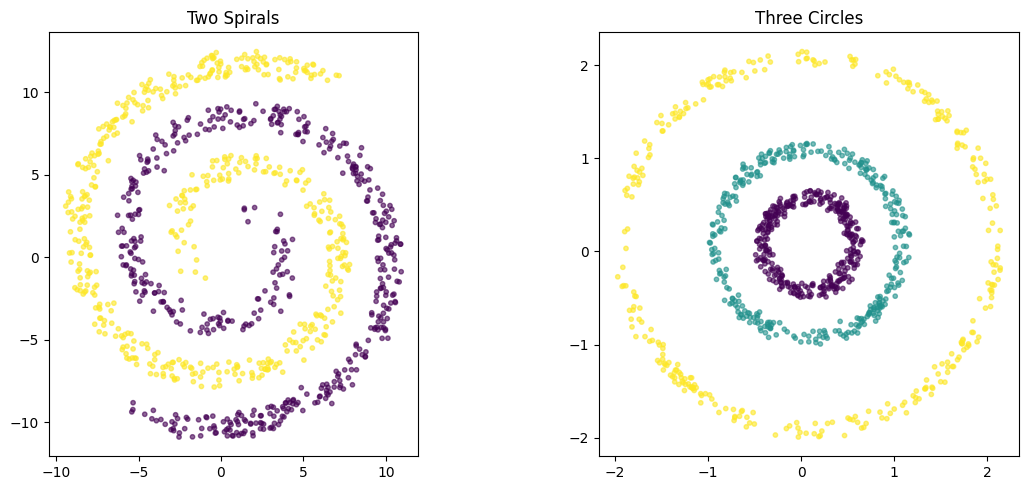

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, cmap='viridis', alpha=0.6, s=10)
axes[0].set_title('Two Spirals')
axes[0].set_aspect('equal')
axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis', alpha=0.6, s=10)
axes[1].set_title('Three Circles')
axes[1].set_aspect('equal')
plt.tight_layout()
plt.show()

### Part A: Logistic Regression

1. Two Spirals:

In [13]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spiral, y_spiral, test_size=0.2, random_state=42)

clf_spiral = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf_spiral.fit(X_train_s, y_train_s)
train_acc_s = accuracy_score(y_train_s, clf_spiral.predict(X_train_s))
test_acc_s = accuracy_score(y_test_s, clf_spiral.predict(X_test_s))

print_metrics("Two Spirals - Linear Classifier", train_acc_s, test_acc_s)



Two Spirals - Linear Classifier:
  Train Accuracy: 0.6562
  Test Accuracy: 0.6650
  Test Classification Error: 0.3350


2. Three Circles:

In [14]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_circles, y_circles, test_size=0.2, random_state=42)

clf_circles = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf_circles.fit(X_train_c, y_train_c)
train_acc_c = accuracy_score(y_train_c, clf_circles.predict(X_train_c))
test_acc_c = accuracy_score(y_test_c, clf_circles.predict(X_test_c))

print_metrics("Three Circles - Linear Classifier", train_acc_c, test_acc_c)


Three Circles - Linear Classifier:
  Train Accuracy: 0.3325
  Test Accuracy: 0.2800
  Test Classification Error: 0.7200


### Part B - KERNEL PCA with Gaussian Kernel

In [16]:
class KernelPCA:
    def __init__(self, n_components = None, sigma = 1.0):
        self.n_components = n_components
        self.sigma = sigma
        self.X_fit = None
        self.eigenvectors = None
        self.eigenvalues = None

    def fit(self, X):
        self.X_fit = X
        N = X.shape[0]

        # pairwise sq. euclidean dist
        X2 = np.sum(X*X, axis=1)
        DIST_euclid = X2.reshape(-1, 1) + X2.reshape(1, -1) - 2 * (X@X.T)

        # get kernel matrix NXN
        K = np.exp(-DIST_euclid / self.sigma)

        # now normalize the kernel
        U = np.ones((N, N)) / N
        Kn = K - U @ K - K @ U + U @ K @ U

        eigenvalues, eigenvectors = np.linalg.eig(Kn)

        idx = eigenvalues.argsort()[::-1]
        self.eigenvalues = eigenvalues[idx].real
        self.eigenvectors = eigenvectors[:, idx].real

        if self.n_components is not None:
            self.eigenvectors = self.eigenvectors[:, :self.n_components]
            self.eigenvalues = self.eigenvalues[:self.n_components]

        return self

    def transform(self, X):
        N = self.X_fit.shape[0]

        if X.shape == self.X_fit.shape and np.allclose(X, self.X_fit):
            # Compute kernel matrix
            X2 = np.sum(X * X, axis=1)
            DIST_euclid = X2.reshape(-1, 1) + X2.reshape(1, -1) - 2 * (X @ X.T)
            K = np.exp(-DIST_euclid / self.sigma)

            # Center the kernel
            U = np.ones((N, N)) / N
            Kn = K - U @ K - K @ U + U @ K @ U

            # Project
            return Kn @ self.eigenvectors
        else:
            # For test data (out-of-sample extension)
            # Compute kernel between test and training data
            X2_test = np.sum(X * X, axis=1)
            X2_train = np.sum(self.X_fit * self.X_fit, axis=1)
            DIST_euclid = X2_test.reshape(-1, 1) + X2_train.reshape(1, -1) - 2 * (X @ self.X_fit.T)
            K_test = np.exp(-DIST_euclid / self.sigma)

            # Center with respect to training data
            U = np.ones((N, N)) / N
            K_train_mean = np.mean(K_test, axis=1, keepdims=True)
            K_test_centered = K_test - K_train_mean - np.mean(U, axis=0) + np.mean(U)

            return K_test_centered @ self.eigenvectors

### Part C: Test different values of T as specified

In [19]:
T_values = [10, 50, 100, 500]
sigma_spiral = 5  # As specified by TA
sigma_circles = 1  # As specified by TA

print("\n" + "="*60)
print("KERNEL PCA RESULTS - TWO SPIRALS (sigma=5)")
print("="*60)

for T in T_values:
    kpca = KernelPCA(n_components=T, sigma=sigma_spiral)
    kpca.fit(X_train_s)

    X_train_kpca = kpca.transform(X_train_s)
    X_test_kpca = kpca.transform(X_test_s)

    clf = OneVsRestClassifier(LogisticRegression(max_iter=2000))
    clf.fit(X_train_kpca, y_train_s)

    train_acc = accuracy_score(y_train_s, clf.predict(X_train_kpca))
    test_acc = accuracy_score(y_test_s, clf.predict(X_test_kpca))

    print(f"T={T:3d}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f}")


KERNEL PCA RESULTS - TWO SPIRALS (sigma=5)
T= 10: Train Accuracy=0.7262, Test Accuracy=0.7200
T= 50: Train Accuracy=0.9975, Test Accuracy=0.9900
T=100: Train Accuracy=0.9988, Test Accuracy=0.9900
T=500: Train Accuracy=0.9988, Test Accuracy=0.9900


In [18]:
print("\n" + "="*60)
print("KERNEL PCA RESULTS - THREE CIRCLES (sigma=1)")
print("="*60)

for T in T_values:
    kpca = KernelPCA(n_components=T, sigma=sigma_circles)
    kpca.fit(X_train_c)

    X_train_kpca = kpca.transform(X_train_c)
    X_test_kpca = kpca.transform(X_test_c)

    clf = OneVsRestClassifier(LogisticRegression(max_iter=2000))
    clf.fit(X_train_kpca, y_train_c)

    train_acc = accuracy_score(y_train_c, clf.predict(X_train_kpca))
    test_acc = accuracy_score(y_test_c, clf.predict(X_test_kpca))

    print(f"T={T:3d}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f}")


KERNEL PCA RESULTS - THREE CIRCLES (sigma=1)
T= 10: Train Accuracy=1.0000, Test Accuracy=0.4000
T= 50: Train Accuracy=1.0000, Test Accuracy=0.9050
T=100: Train Accuracy=1.0000, Test Accuracy=0.9050
T=500: Train Accuracy=1.0000, Test Accuracy=0.9050
